In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from utils import nan_gmean, METATHERIAN_ORDERS

In [2]:
anage_df = pd.read_csv('../data/112321_AnAge_cleaned.csv', index_col=0).set_index('Binomial Name')
pantheria_df = pd.read_csv('../data/PanTHERIA_1-0_WR05_Aug2008_cleaned.csv', index_col=0).set_index('Binomial Name')

# Pairs of columns to match up between the datasets.
column_pairs_df = pd.read_excel('../data/anage_pantheria_column_pairs.xlsx').fillna('')

In [3]:
column_pairs_df

,anage_col,pantheria_col,merged_col,is_numeric,comment
0,Order,Order,Order,False,
1,Family,Family,Family,False,
2,Genus,Genus,Genus,False,
3,Species,Species,Species,False,
4,PlacentalMammal,PlacentalMammal,PlacentalMammal,False,
5,Body mass (g),AdultBodyMass (g),AdultBodyMass (g),True,
6,Birth weight (g),NeonateBodyMass (g),NeonateBodyMass (g),True,
7,Litter/Clutch size,LitterSize (number),LitterSize (number),True,
8,Gestation/Incubation (days),GestationLen (days),GestationLen (d),True,
9,Inter-litter/Interbirth interval,InterbirthInterval (d),InterbirthInterval (d),True,


In [4]:
anage_df.columns.values

array(['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus',
       'Species', 'Common name', 'Female maturity (days)',
       'Male maturity (days)', 'Gestation/Incubation (days)',
       'Weaning (days)', 'Litter/Clutch size',
       'Litters/Clutches per year', 'Inter-litter/Interbirth interval',
       'Birth weight (g)', 'Weaning weight (g)', 'Adult weight (g)',
       'Growth rate (1/days)', 'Maximum longevity (yrs)', 'Source',
       'Specimen origin', 'Sample size', 'Data quality', 'IMR (per yr)',
       'MRDT (yrs)', 'Metabolic rate (W)', 'Body mass (g)',
       'Temperature (K)', 'References', 'PlacentalMammal',
       'Maximum longevity (months)', 'YoungPerYear_Litters',
       'YoungPerYear_Interval', 'YoungPerYear_Estimated',
       'YoungMassPerYear_Estimated (g)'], dtype=object)

In [5]:
pantheria_df.columns.values

array(['Order', 'Family', 'Genus', 'Species', 'AdultBodyMass (g)',
       'AdultForearmLen (mm)', 'AdultHeadBodyLen (mm)',
       'AgeatEyeOpening (days)', 'AgeatFirstBirth (days)',
       'BasalMetRate (mLO2hr)', 'BasalMetRateMass (g)',
       'DispersalAge (days)', 'GestationLen (days)',
       'InterbirthInterval (d)', 'LitterSize (number)',
       'LittersPerYear (number)', 'MaxLongevity (months)',
       'NeonateBodyMass (g)', 'NeonateHeadBodyLen (mm)',
       'SexualMaturityAge (days)', 'TeatNumber (number)',
       'WeaningAge (days)', 'WeaningBodyMass (g)',
       'WeaningHeadBodyLen (mm)', 'References', 'PlacentalMammal',
       'YoungPerYear_Litters (number)', 'YoungPerYear_Interval (number)',
       'YoungPerYear_Estimated (number)',
       'YoungMassPerYear_Estimated (g)'], dtype=object)

In [6]:
intersecting_names = set(pantheria_df.index.values).intersection(anage_df.index.values)
union_names = set(pantheria_df.index.values).union(anage_df.index.values)
n_intersecting = len(intersecting_names)
n_total_names = len(union_names)
n_pantheria_only = len(set(pantheria_df.index.values).difference(anage_df.index.values))
n_anage_only = len(set(anage_df.index.values).difference(pantheria_df.index.values))
intersecting_names = list(intersecting_names)

print('AnAge DB {0} entries'.format(anage_df.index.size))
print('Pantheria DB {0} entries'.format(pantheria_df.index.size))
print('{0} entries with matching binomial names'.format(n_intersecting))
print('{0} binomial names in AnAge only'.format(n_anage_only))
print('{0} binomial names in Pantheria only'.format(n_pantheria_only))
print('{0} total binomial names'.format(n_total_names))

AnAge DB 990 entries
Pantheria DB 5416 entries
955 entries with matching binomial names
35 binomial names in AnAge only
4461 binomial names in Pantheria only
5451 total binomial names


In [7]:
cols2test = 'Order,Family,Genus,Species,PlacentalMammal'.split(',')

# Make sure the phylogenetic information matches.
mismatch_count = 0
case_count = 0
for idx in union_names:
    if idx not in pantheria_df.index or idx not in anage_df.index:
        continue 
    case_count += 1
        
    for col in cols2test:
        panv = pantheria_df.loc[idx,col]
        anv = anage_df.loc[idx,col]
        if panv != anv:
            print(idx)
            print('\t{0} "{1}" != "{2}"'.format(col, panv, anv))
            mismatch_count += 1
            
print(mismatch_count, 'mismatches of', case_count, 'cases')

# We see that the phylogenetic information matches in almost all cases (21/955).
# The mismatches are all family name discrepancies. 
# After merging we will replace all the problematic Pantheria families 
# with the matching values from AnAge since that DB is more recently updated. 

Callithrix jacchus
	Family "Cebidae" != "Callitrichidae"
Ziphius cavirostris
	Family "Ziphiidae" != "Hyperoodontidae"
Leontopithecus chrysomelas
	Family "Cebidae" != "Callitrichidae"
Callimico goeldii
	Family "Cebidae" != "Callitrichidae"
Saguinus midas
	Family "Cebidae" != "Callitrichidae"
Saguinus labiatus
	Family "Cebidae" != "Callitrichidae"
Berardius bairdii
	Family "Ziphiidae" != "Hyperoodontidae"
Saguinus oedipus
	Family "Cebidae" != "Callitrichidae"
Saguinus leucopus
	Family "Cebidae" != "Callitrichidae"
Callithrix geoffroyi
	Family "Cebidae" != "Callitrichidae"
Saguinus geoffroyi
	Family "Cebidae" != "Callitrichidae"
Hyperoodon ampullatus
	Family "Ziphiidae" != "Hyperoodontidae"
Saguinus mystax
	Family "Cebidae" != "Callitrichidae"
Callithrix penicillata
	Family "Cebidae" != "Callitrichidae"
Miniopterus schreibersii
	Family "Vespertilionidae" != "Miniopteridae"
Leontopithecus rosalia
	Family "Cebidae" != "Callitrichidae"
Saguinus bicolor
	Family "Cebidae" != "Callitrichidae"
K

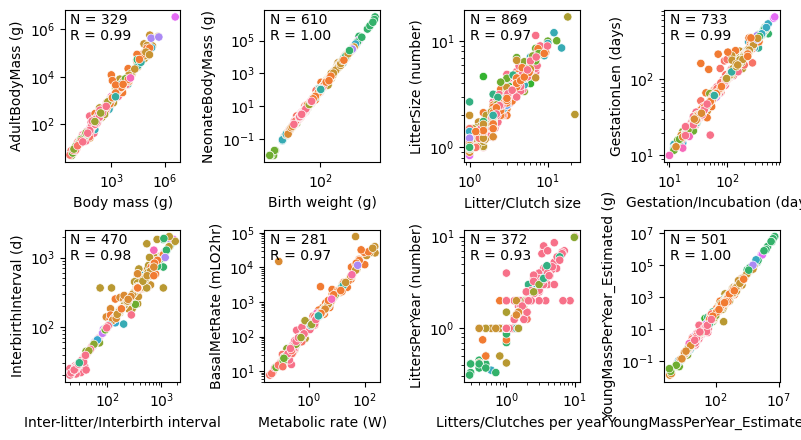

In [8]:
# Comparing the AnAge and Pantheria datasets by plotting the most interesting
# columns (for our purposes) against each other. Looks like they are consistent with occasional outliers.

# tuples of (AnAge, Pantheria) column names
column_pairs = [('Body mass (g)', 'AdultBodyMass (g)'),
                ('Birth weight (g)', 'NeonateBodyMass (g)'),
                ('Litter/Clutch size', 'LitterSize (number)'),
                ('Gestation/Incubation (days)', 'GestationLen (days)'),
                ('Inter-litter/Interbirth interval', 'InterbirthInterval (d)'),
                ('Metabolic rate (W)', 'BasalMetRate (mLO2hr)'),
                ('Litters/Clutches per year', 'LittersPerYear (number)'),
                ('YoungMassPerYear_Estimated (g)', 'YoungMassPerYear_Estimated (g)')]
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8,4.5))
flat_axs = axs.flatten()

for (anage_col, pantheria_col), my_ax in zip(column_pairs, flat_axs):
    plt.sca(my_ax)
    
    plt.xscale('log')
    plt.yscale('log')
    
    # grab data for both columns
    x_data = anage_df.loc[intersecting_names][anage_col]
    y_data = pantheria_df.loc[intersecting_names][pantheria_col]
    
    # remove NaNs - needed for calculating correlation
    mask = np.logical_and(x_data.notnull(), y_data.notnull())
    x_data = x_data[mask]
    y_data = y_data[mask]
    
    sns.scatterplot(x=x_data, y=y_data, hue=pantheria_df.Order, legend=False)
    
    # Calculate pearson correlation of log-transformed data
    r_val = pearsonr(np.log(x_data), np.log(y_data))
    N_obs = x_data.size
    plt.text(0.05, 0.8, 'N = {0:d}\nR = {1:.2f}'.format(N_obs, r_val[0]),
             transform=my_ax.transAxes)
    
plt.tight_layout()
plt.show()

In [ ]:
# Now we will merge the two datasets following the column pair definitions in column_pairs_df
data_dict = dict((c,[]) for c in column_pairs_df.merged_col)
data_dict['BinomialName'] = []

# Textual columns found in both datasets are mostly phylogenetic in nature. 
both_datasets = np.logical_and(column_pairs_df.anage_col.str.len(), column_pairs_df.pantheria_col.str.len())
mask = np.logical_and(both_datasets, column_pairs_df.is_numeric == False)
text_cols_both = column_pairs_df[mask]
print('Textual columns in both datasets')
print(text_cols_both.merged_col.values)

# Textual found in one dataset have dataset specific merged names
one_dataset = np.logical_xor(column_pairs_df.anage_col.str.len(), column_pairs_df.pantheria_col.str.len())
mask = np.logical_and(one_dataset, column_pairs_df.is_numeric == False)
text_cols_one = column_pairs_df[mask]
print('Textual columns in one dataset')
print(text_cols_one.merged_col.values)

# Numeric columns found are merged by geometric mean. 
numeric_cols = column_pairs_df[column_pairs_df.is_numeric == True]
print('Numeric columns')
print(numeric_cols.merged_col.values)


# Make a merged row for each binomial name in the union of the two datasets, 
for bin_name in union_names:
    data_dict['BinomialName'].append(bin_name)
    in_anage = bin_name in anage_df.index
    in_pantheria = bin_name in pantheria_df.index
    
    # Prefer AnAge for phylogenetic data since it is newer
    for idx, row in text_cols_both.iterrows():
        my_val = None
        if in_anage:
            my_val = anage_df.loc[bin_name, row.anage_col]
        elif in_pantheria:
            my_val = pantheria_df.loc[bin_name, row.pantheria_col]
        else:
            assert False
            
        data_dict[row.merged_col].append(my_val)
        
    # Merge numeric data by geometric mean
    for idx, row in numeric_cols.iterrows():
        anage_val, pantheria_val = np.nan, np.nan
        if in_anage and row.anage_col != '':
            anage_val = anage_df.loc[bin_name, row.anage_col]
        elif in_pantheria and row.pantheria_col != '':
            pantheria_val = pantheria_df.loc[bin_name, row.pantheria_col]
            
        my_val = nan_gmean(pd.Series([anage_val, pantheria_val]))
        data_dict[row.merged_col].append(my_val)
    
    # Textual found in one dataset have dataset specific merged names
    # to indicate where they came from. 
    for idx, row in text_cols_one.iterrows():
        my_val = None
        if row.anage_col != '':
            if in_anage:
                my_val = anage_df.loc[bin_name, row.anage_col]
        elif row.pantheria_col != '':
            if in_pantheria:
                my_val = pantheria_df.loc[bin_name, row.pantheria_col]
        else:
            assert False
        data_dict[row.merged_col].append(my_val)


Textual columns in both datasets
['Order' 'Family' 'Genus' 'Species' 'PlacentalMammal']
Textual columns in one dataset
['RefsAnAge' 'RefsPanTHERIA']
Numeric columns
['AdultBodyMass (g)' 'NeonateBodyMass (g)' 'LitterSize (number)'
 'GestationLen (d)' 'InterbirthInterval (d)' 'LittersPerYear (number)'
 'WeaningAge (d)' 'WeaningBodyMass (g)' 'FemaleSexualMaturity (d)'
 'MaleSexualMaturity (d)' 'PantheriaSexualMaturity (d)'
 'AgeAtFirstBirth (d)' 'MaxLongevity (m)' 'BasalMetabolicRate (W)'
 'BasalMetabolicRate (mLO2hr)' 'BasalMetabolicRate (g)']


AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

In [ ]:
merged_df = pd.DataFrame(data_dict)

# Replace the family names that don't match between the DBs to follow AnAge.
to_replace = {"Cebidae": "Callitrichidae",
              "Ziphiidae": "Hyperoodontidae",
              "Physeteridae": "Kogiidae",
              "Vespertilionidae": "Miniopteridae"
              }
merged_df.replace(to_replace)

# Calculate num. young per year:
# Have two values that can be used to get litters/year.
# 1/ Litters per year and 2/ Inter-litter interval
litter_size = merged_df['LitterSize (number)']
litters_per_year = merged_df['LittersPerYear (number)']
interbirth_interval_d = merged_df['InterbirthInterval (d)']
litters_per_year_inferred = 365.0/interbirth_interval_d
young_per_year_litters = litter_size / litters_per_year
young_per_year_interval = litter_size / litters_per_year_inferred

# Save that data
merged_df['YoungPerYear_Litters (number)'] = young_per_year_litters
merged_df['YoungPerYear_Interval (number)'] = young_per_year_interval

# The geometric mean of the two estimates is taken for plotting and fitting.
gmeans = pd.concat([young_per_year_litters, young_per_year_interval], axis=1).apply(nan_gmean, axis=1)
merged_df['YoungPerYear_Estimated (number)'] = gmeans

# Convert to a mass/year estimate using the mass of a neonate.
neonate_mass_g = merged_df['NeonateBodyMass (g)']
merged_df['YoungMassPerYear_Estimated (g)'] = neonate_mass_g*gmeans

In [ ]:
# Load the basal metabolic rate data from Savage et al. 2004. 
savage_df = pd.read_excel('../data/savage2004_BMR.xlsx')
# Rename columns to match merged_df
savage_df.columns = 'Order,Family,BinomialName'.split(',') + savage_df.columns[3:].tolist()

# Index on "BinomialName"
savage_df = savage_df.set_index('BinomialName')

# Merge it into our dataframe so that we have everything in one file now.
all_merged_df = merged_df.join(savage_df, on='BinomialName', how='outer', rsuffix='_savage04')

# Set PlacentalMammal for the species in Savage '04 without a match in the merged_df
mask = all_merged_df.PlacentalMammal.isnull()
all_merged_df.loc[mask, 'PlacentalMammal'] = all_merged_df.loc[mask].Order.isin(METATHERIAN_ORDERS)

all_merged_df.head(3)

,Order,Family,Genus,Species,PlacentalMammal,AdultBodyMass (g),NeonateBodyMass (g),LitterSize (number),GestationLen (d),InterbirthInterval (d),...,YoungMassPerYear_Estimated (g),Order_savage04,Family_savage04,mass_g,BMR_W,BMR_MJ_per_day,species_average_mass_g,species_average_BMR_W,species_average_BMR_MJ_per_day,ref
0.0,Rodentia,Cricetidae,Calomys,callidus,True,27.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,Rodentia,Echimyidae,Proechimys,oconnelli,True,284.99,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,Rodentia,Gliridae,Muscardinus,avellanarius,True,23.50,0.8,4.0,23.0,50.0,...,0.967037,Rodentia,Myoxidae,23.5,0.351,0.030326,23.5,0.351,0.030326,White & Seymour (2003)


In [ ]:
# Check that the Family and Order are the same. 
fam_check = np.logical_and(all_merged_df.Family.notnull(), all_merged_df['Family_savage04'].notnull())
fam_check = np.logical_and(fam_check, all_merged_df['Family_savage04'] != all_merged_df['Family'])
ord_check = np.logical_and(all_merged_df.Order.notnull(), all_merged_df['Order_savage04'].notnull())
ord_check = np.logical_and(ord_check, all_merged_df['Order_savage04'] != all_merged_df['Order'])

fam_matches = (all_merged_df['Family_savage04'] == all_merged_df['Family']).sum()
ord_matches = (all_merged_df['Order_savage04'] == all_merged_df['Order']).sum()

print('Family level: {0} matches, {1} mismatches'.format(fam_matches, fam_check.sum()))
print('Order level: {0} matches, {1} mismatches'.format(ord_matches, ord_check.sum()))

#print('Families:')
#for idx, row in all_merged_df[fam_check].iterrows():
#    print('Savage {0}, merged_df {1}'.format(row.Family_savage04, row.Family))
#print('\nOrders:')
#for idx, row in all_merged_df[ord_check].iterrows():
#    print('Savage {0}, merged_df {1}'.format(row.Order_savage04, row.Order))
    
# Looks like they do not match entirely... 
# From a brief inspection it seems like these are mostly different names for the same groups.
# TODO: deeper inspection of the mismatches. 

Family level: 728 matches, 203 mismatches
Order level: 756 matches, 175 mismatches


<AxesSubplot:xlabel='AdultBodyMass (g)', ylabel='BMR_W'>

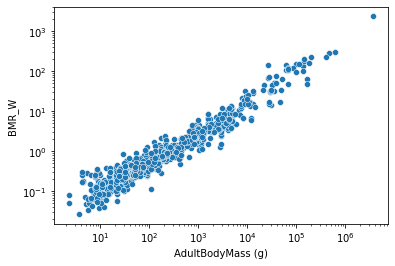

In [ ]:
# As a test, plot body masses from Anage+Pantheria against BMR from Savage '04.
# The obvious power-law scaling suggests that we mostly got the matching right. 
plt.figure()
plt.xscale('log')
plt.yscale('log')

sns.scatterplot(data=all_merged_df, x='AdultBodyMass (g)', y='BMR_W')

In [ ]:
all_merged_df.to_csv('../data/merged_animal_traits.csv')
placental_mammals = all_merged_df[all_merged_df.PlacentalMammal]
placental_mammals.to_csv('../data/merged_animal_traits_placental_only.csv')

In [ ]:
placental_mammals.columns

Index(['Order', 'Family', 'Genus', 'Species', 'PlacentalMammal',
       'AdultBodyMass (g)', 'NeonateBodyMass (g)', 'LitterSize (number)',
       'GestationLen (d)', 'InterbirthInterval (d)', 'LittersPerYear (number)',
       'WeaningAge (d)', 'WeaningBodyMass (g)', 'FemaleSexualMaturity (d)',
       'MaleSexualMaturity (d)', 'PantheriaSexualMaturity (d)',
       'AgeAtFirstBirth (d)', 'MaxLongevity (m)', 'BasalMetabolicRate (W)',
       'BasalMetabolicRate (mLO2hr)', 'BasalMetabolicRate (g)', 'RefsAnAge',
       'RefsPanTHERIA', 'BinomialName', 'YoungPerYear_Litters (number)',
       'YoungPerYear_Interval (number)', 'YoungPerYear_Estimated (number)',
       'YoungMassPerYear_Estimated (g)', 'Order_savage04', 'Family_savage04',
       'mass_g', 'BMR_W', 'BMR_MJ_per_day', 'species_average_mass_g',
       'species_average_BMR_W', 'species_average_BMR_MJ_per_day', 'ref'],
      dtype='object')